## Two sample independent t-test

Used to compare the means between two categories of samples

In this study we are going use the 'season', 'month', 'holiday', 'workingday', 'weathersit', 'temp', 'cnt' columns

In [58]:
!pip install researchpy

# researchpy combines pandas, scipystats and statsmodel to get more complete information in a single API call

Importing the necessary libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# The sklearn.preprocessing.scale is used to preprocess data by standardizng the numeric values. 
# Standardizing involves centering numeric values in the form of z-scores around the mean
from sklearn.preprocessing import scale


from scipy import stats
import researchpy as rp

Reading in the dataset.

In [7]:
bike = pd.read_csv("C:/Users/MANU/Desktop/Datasets/Pluralsight/Bike_sharing_dataset/day.csv")

Inspecting the data

In [8]:
bike.shape

(731, 16)

In [9]:
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [10]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 88.6+ KB


In [11]:
bike.nunique()

instant       731
dteday        731
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          499
atemp         690
hum           595
windspeed     650
casual        606
registered    679
cnt           696
dtype: int64

Extracting the data we will use in this analysis

In [12]:
bikes = bike[['season', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp', 'cnt']]

In [13]:
bikes.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


###### we are going to test if the average(mean) number of bikes rented on working days vs. non-working days is different and if this difference is statistically significant

Grouping by the working day and describing by the cnt column

In [14]:
bikes.groupby('workingday')['cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,231.0,4330.168831,2052.141245,605.0,2710.50,4459.0,5907.5,8714.0
1,500.0,4584.820000,1878.415583,22.0,3344.25,4582.0,5987.5,8362.0


###### Observations:
1. We have 231 and 500 records for non-working and working days respectively'
2. The means for non-working=4330.168 and working days=4584.82 are different. But is this difference statistically significant?

Let's visualize this with a box plot

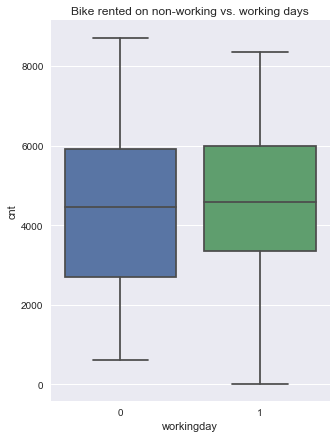

In [15]:
plt.figure(figsize = (5, 7))
sns.boxplot(x='workingday', y='cnt', data=bikes)
plt.title('Bike rented on non-working vs. working days')
plt.show()

###### Observation(s):
1. The median values for working and non-working days are almost eaqual

In preparation for the two sample t-test, lets split the data into two eaqual parts

In [16]:
# Data for working days
sample_01 = bikes[bikes['workingday'] == 1]

# Data for non-working days
sample_02 = bikes[bikes['workingday'] == 0]

# Checking on the shape of the samples
sample_01.shape, sample_02.shape

((500, 7), (231, 7))

The two samples are not of equal sizes and t-test requires the samples to be of equal size, so lets equate them.

In [17]:
# Data for working days
sample_01 = bikes[bikes['workingday'] == 1].sample(231)

#Checking on the shape of the samples
sample_01.shape, sample_02.shape

((231, 7), (231, 7))

###### One of the assumptions of the t-test is that the variance of the two groups must be equal

To the check this assumption of equality in variance for our two samples, we use the Levene's test.

The null hypothesis for Levene's test is the two groups have equal variance.

We will use a significance level (alpha) = 0.05

In [18]:
stats.levene(sample_01['cnt'], sample_02['cnt'])

LeveneResult(statistic=3.0508388101686754, pvalue=0.081362894521515822)

###### observations:
1. The test statistic value for the levene test for equal variance is 3.05

2. The p-value is 0.081 which is greater than alpha=0.05. We fail to reject the null hypothesis and conclude that the variance of sample_01 and sample_02 are equal.

###### The second assumption of t-test is that the residuals between the two samples must be normally distributed.
The are three ways of checking for this assumption:
1. plotting the histogram of the residuals after standardizing to z-score using the imported scale function

2. using the probability plot / qq plot for the standardized residuals

3. Shapiro-Wilk test for normality

Obtainin the residuals and standardizing them.

In [51]:
# calculating the residuals using numpy's array function
diff = np.array(sample_01['cnt']) - np.array(sample_02['cnt'])

# Standardizing the residuals to z-scores
diff = scale(diff)


C:\Users\MANU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


###### 1. Plotting the histogram of the standardized residuals

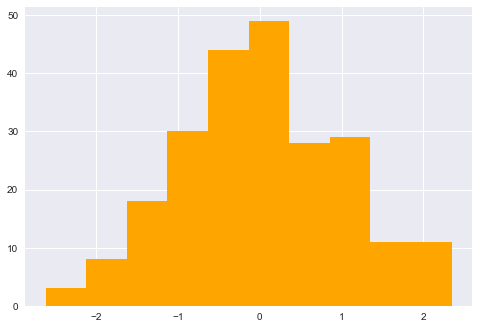

In [52]:
plt.hist(diff, color='orange')
plt.show()

The residuals seem to follow a normal distribution. The histogram is ruther a rough check. method 2 is more refined for this check

###### 2. Using the probability plot / qq plot for the standardized residuals

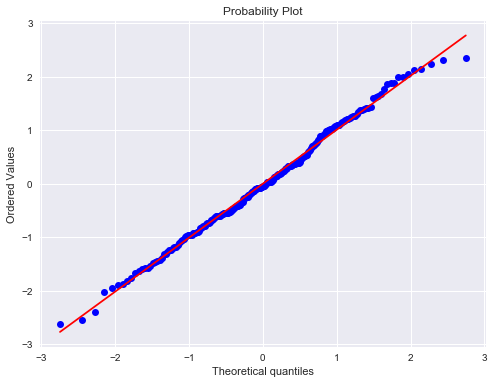

In [21]:
plt.figure(figsize=(8, 6))
stats.probplot(diff, plot=plt, dist='norm')
plt.show()

###### Observation(s):
1. Apart from the residuals 3 std away from the mean, the residuals closely follows normal distribution (red line)
2. This implies that the second assumption has been met by our two samples

###### Shapiro-Wilk test for normality
This test produces a test statistic value and a p-value.

The null hypothesis is that the data is normally distributed,

In [22]:
stats.shapiro(diff)

(0.9941636323928833, 0.5116085410118103)

###### Observation(s):
1. The p-value for the shapiro-wilk normality test is 0.5116 which is greater than 0.05, We fail to reject the null hypothesis and conclude that the residuals are normaly distributed.

Since all assumptions for the independent two sample t-test have been met, we can proceed with the test

In [23]:
stats.ttest_ind(sample_01['cnt'], sample_02['cnt'])

Ttest_indResult(statistic=1.741035609177626, pvalue=0.082345921219703508)

###### Observations:
1. The test statistic value is 1.741

2. The p-value is 0.0823 which is greater than 0.05. We therefore fail to reject the null hypothesis and conclude that the observed difference in the mean number of bikes rented on working days against the mean number of bikes rented on non-working days is not statistically significant and the difference is due to chance.

3. Wether it's  a working day or not, it has no effect on the number of bikes rented.

###### The researchpy module can also we used to carry out this test as follows

In [24]:
describe, result = rp.ttest(sample_01['cnt'], sample_02['cnt'])

Let's view the output

In [25]:
describe

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,cnt,231.0,4650.844156,1904.026715,125.275760,4404.009345,4897.678967
1,cnt,231.0,4330.168831,2052.141245,135.020981,4064.132702,4596.204960
2,combined,462.0,4490.506494,1983.825868,92.295932,4309.133614,4671.879373


In [26]:
print(result)

          Independent t-test   results
0  Difference (cnt - cnt) =   320.6753
1      Degrees of freedom =   460.0000
2                       t =     1.7410
3   Two side test p value =     0.0823
4  Difference < 0 p value =     0.9588
5  Difference > 0 p value =     0.0412
6               Cohen's d =     0.1620
7               Hedge's g =     0.1617
8           Glass's delta =     0.1684
9                       r =     0.0809


We still have the test statistic (t) = 1.7410 and p-value = 0.0823

## Welch's t-test
This is used a substitute to two sample independent t-test when the samples do not have equal variances

Let's see if the temperature on a particular day has an effect on the number of bikes rented on that day

In [27]:
bikes.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


The t-test is performed on two groups of data by dividing the data using some categorical variables. 

The temperature data we have is continous but in order to perform t-test, we will create categories from this data

Let's first visual the distribution of temperature values

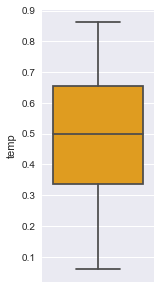

In [28]:
plt.figure(figsize=(2,5))
sns.boxplot(y='temp', data=bikes, color='orange')
plt.show()

It is clear that temperature values have been scaled and range between 0 to 1 with the median being 0.5

Now lets create a new column that categorizes the temperature column based on if the temperature is greater than or equal to the mean

In [53]:
# Categorizing the temperature into high or low if the temperature is greater than or less than the mean temperature respectively
bikes['temp_category'] = bikes['temp'] > (bikes['temp'].mean())

C:\Users\MANU\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
bikes.sample(7)

,season,mnth,holiday,workingday,weathersit,temp,cnt,temp_category
147,2,5,0,0,1,0.655833,4758,True
683,4,11,0,1,1,0.289167,5495,False
497,2,5,0,0,1,0.564167,7429,True
501,2,5,0,1,1,0.636667,7424,True
197,3,7,0,0,1,0.719167,5302,True
216,3,8,0,1,1,0.710833,4866,True
404,1,2,0,1,1,0.265000,3830,False


Generating some summary statistics

In [31]:
bikes.groupby('temp_category')['cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
temp_category,,,,,,,,
False,364.0,3387.664835,1691.340133,22.0,1964.5,3301.0,4513.5,8090.0
True,367.0,5611.904632,1475.698228,1115.0,4548.5,5336.0,6897.5,8714.0


###### Observations:
1. We have 364 records when the temp was below the mean temp and 367 when the temp was above the mean
2. The mean number of bikes rented when temp was below the mean was 3387 and 5611 when the temp was above the mean temp

Lets visualize this difference between cooler and warmer days using boxplots

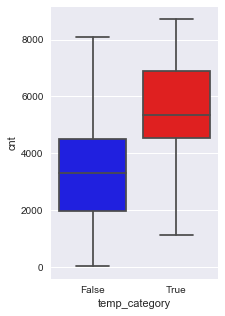

In [32]:
plt.figure(figsize=(3,5))
sns.boxplot(x='temp_category', y='cnt', data=bikes, palette={False:'blue', True: 'red'})
plt.show()

Indeed there is a huge difference in bikes rented on cool days as compared to the number rented on warm days.

The question that begs is this difference statistically significant. Well, the independent t-test will tell us

Spliting the data into two samples

In [33]:
sample_1 = bikes[bikes['temp_category'] == True]
sample_2 = bikes[bikes['temp_category'] == False]

sample_1.shape, sample_2.shape

((367, 8), (364, 8))

The samples are of different sizes, let's equalize them

In [34]:
# Reducing the size of sample 1
sample_1 = sample_1.sample(364)

sample_1.shape, sample_2.shape

((364, 8), (364, 8))

###### Checking assumption 1: Equality of variance

In [35]:
stats.levene(sample_1['cnt'], sample_2['cnt'])

LeveneResult(statistic=4.6265387984533577, pvalue=0.031810398021999288)

###### Observations:
1. Levene's test statistic value = 4.6265
2. p-value = 0.0318 which is less than 0.05, thus we reject the null hypothesis that the variances of samples_1 and sample_2 are equal and conclude that the variances are NOT EQUAL
3. With unequal variances, we must use welch's t-test instead of independed t-test

###### Checking assumption 2: Residuals must be normally distributed

Plotting the probability plot of the residuals

C:\Users\MANU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


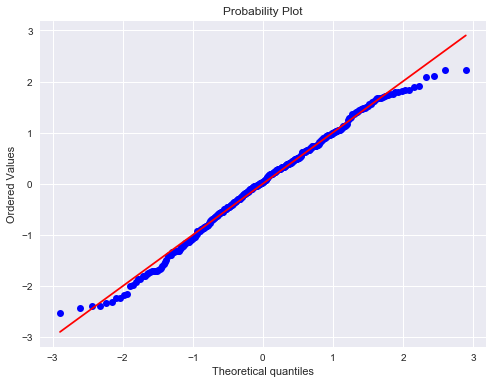

In [55]:
# calculating the residuals and standardizing them
residual = scale(np.array(sample_1['cnt']) - np.array(sample_2['cnt']))

# ploting the probability plot or qq plot of the residuals
plt.figure(figsize=(8,6))
stats.probplot(residual, plot=plt, dist='norm')
plt.show()

Testing for nomarlity using the Shapiro-Wilk test for nomality

In [57]:
stats.shapiro(residual)

(0.9908739924430847, 0.023703299462795258)

The probability plot show that the residuals are normaly distributed.

The Shapiro-Wilk test show that the residuals are not normally distributed since the p-value is less than 0.05

###### Performing welche's t-test

In [38]:
discriptives, results = rp.ttest(sample_1['cnt'], sample_2['cnt'], equal_variances=False)

print(results)

              Welch's t-test    results
0  Difference (cnt - cnt) =   2224.0742
1      Degrees of freedom =    713.0839
2                       t =     18.8961
3   Two side test p value =      0.0000
4  Difference < 0 p value =      1.0000
5  Difference > 0 p value =      0.0000
6               Cohen's d =      1.4007
7               Hedge's g =      1.3992
8           Glass's delta =      1.5057
9                       r =      0.5776


###### Conclusion: 
1. The t-statistic for the welch's t-test is 18.9096 with a p-value of 0.00

2. p-value = 0.00 is less than significant level=0.05, We therefore reject the null hypothesis and conclude that the differences in the mean number of bikes rented on cool days as compared to those rented on warm days is statistically significant. This implies that temperature of a day has an effect on the number of bikes rented on that day.


## Paired difference t-test

Involves using one sample but under different conditions

We are going to use the blood pressure dataset to see if the differences in blood pressure before and after an intervention is statistically significant

In [39]:
# Reading in the dataset
bp = pd.read_csv('C:/Users/MANU/Desktop/Datasets/Pluralsight/blood_pressure.csv')

In [40]:
bp.sample(5)

,patient,sex,agegrp,bp_before,bp_after
49,50,Male,60+,170,163
42,43,Male,60+,162,168
101,102,Female,60+,142,141
70,71,Female,30-45,162,133
53,54,Male,60+,173,163


In [41]:
bp.describe().T

,count,mean,std,min,25%,50%,75%,max
patient,120.0,60.500000,34.785054,1.0,30.75,60.5,90.25,120.0
bp_before,120.0,156.450000,11.389845,138.0,147.00,154.5,164.00,185.0
bp_after,120.0,151.358333,14.177622,125.0,140.75,149.5,161.00,185.0


Visualizing the distribution before and after intervention

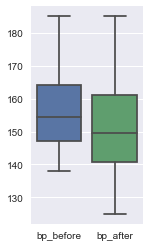

In [42]:
plt.figure(figsize=(2,4))
sns.boxplot(data=bp[['bp_before', 'bp_after']])
plt.show()

###### Observations:
1. The mean bp before intervention was 156.45 while after invention the mean bp was 151.36. Indeed there is a difference between these two means but is the difference statistically significant?

Checking for equality in variance between bp_before and bp_after groups

In [43]:
stats.levene(bp['bp_before'], bp['bp_after'])

LeveneResult(statistic=4.8637290031615974, pvalue=0.028383666362347747)

Observations:
1. The p-value=0.028 is less than 0.05. we reject the null hypothesis and conclude that the variances are not equal.
2. We will use wilcoxon signed-rank test instead of paired difference t-test since the variances are different

Checking for normality i.e. if the residuals are normaly distributed.

In [44]:
# Storing the differences (residuals) in a new column
bp['bp_resid'] = scale(bp['bp_after'] - bp['bp_before'])

C:\Users\MANU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Plotting the probability plot

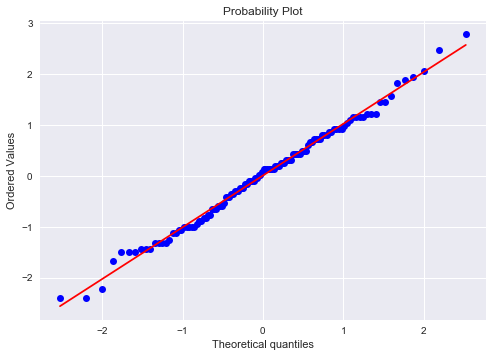

In [45]:
stats.probplot(bp['bp_resid'], plot=plt, dist='norm')
plt.show()

Shapiro-Wilt test for normality

In [46]:
stats.shapiro(bp['bp_resid'])

(0.9926842451095581, 0.7841846942901611)

Conclusion:
1. Both the probability plot and Shapiro-Wilt test for normality show that the residuals are normaly distributed  

If the variance were equal, we would proceed with paired difference t-test as follows

In [47]:
stats.ttest_rel(bp['bp_after'], bp['bp_before'])

Ttest_relResult(statistic=-3.3371870510833657, pvalue=0.0011297914644840823)

###### Wilcoxon signed-rank test
This is used in place of paired difference t-test when the before and after samples have different variance

This test compares the median rather than the mean

In [48]:
rp.ttest(bp['bp_after'], bp['bp_before'], paired=True, equal_variances=False)

,Wilcoxon signed-rank test,results
0,Mean for bp_after =,151.358333
1,Mean for bp_before =,156.450000
2,T value =,2234.500000
3,Z value =,-3.191600
4,Two sided p value =,0.001400
5,r =,-0.206000


###### Observation:
1. The t value is 2234.5
2. The p-value=0.0014 is less than 0.05. We therefore reject the null hypothesis and conclude that the difference in means was statistically significant and the intervention was effective in reducing blood pressure in patients